# NAIVE BAYES

In [209]:
import math
import sys
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import datetime
import pandas as pd
from collections import defaultdict

df=pd.read_csv('/Users/marco/Desktop/DataMining2Project-master-2/datatraining.csv')

In [210]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [211]:
df_val=pd.read_csv('/Users/marco/Desktop/DataMining2Project-master-2/datatest2.csv')

In [212]:
df_val.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [213]:
#approssimo in base al primo dataset sennò da problemi quando concateno

df_val['Temperature']=[round(num, 2) for num in df_val['Temperature']]
df_val['Humidity']=[round(num, 4) for num in df_val['Humidity']]
df_val['Light']=[round(num, 1) for num in df_val['Light']]
df_val['CO2']=[round(num, 2) for num in df_val['CO2']]

In [214]:
df_val.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.76,31.1333,437.3,1029.67,0.005021,1
2,2015-02-11 14:49:00,21.79,31.0000,437.3,1000.00,0.005009,1
3,2015-02-11 14:50:00,21.77,31.1225,434.0,1003.75,0.005022,1
4,2015-02-11 14:51:00,21.77,31.1225,439.0,1009.50,0.005022,1
5,2015-02-11 14:51:59,21.79,31.1333,437.3,1005.67,0.005030,1


In [215]:
df_conc=pd.concat([df,df_val], sort=False)

In [216]:
df_conc.shape

(17895, 7)

In [217]:
df_conc.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


# data preparation

In [218]:
df_conc.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [219]:
#funzione 

def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [220]:
dates = pd.to_datetime(df_conc['date'], infer_datetime_format=True)
df_conc['day'] = dates.dt.day
df_conc['hour'] = dates.dt.time
df_conc['absH'] = dates.dt.hour

#absH è l'orario assoluto. L'ho creato sennò non riusciamo a portarci dietro nemmeno un attributo dell'orario

In [221]:
weekend = []
for i in df_conc.day:
    if i == 7 or i == 8:
        weekend.append(1)
    else:
        weekend.append(0)
weekend = pd.Series(weekend)
df_conc['weekend'] = weekend

In [222]:
df_conc.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,absH,weekend
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,4,17:51:00,17,0
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,4,17:51:59,17,0
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,4,17:53:00,17,0
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,4,17:54:00,17,0
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,4,17:55:00,17,0


Text(0, 0.5, 'Occupancy')

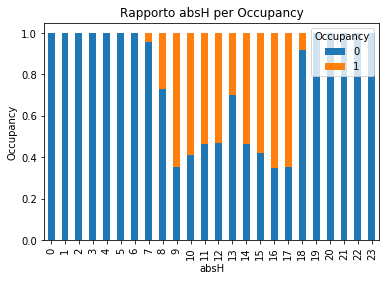

In [223]:
plotHR = pd.crosstab(df_conc['absH'], df_conc['Occupancy'])
plotHRn = plotHR.div(plotHR.sum(1).astype(float), axis=0)
plotHRn.plot(kind='bar', stacked=True, 
                   title='Rapporto absH per Occupancy')
plt.xlabel('absH')
plt.ylabel('Occupancy')

In [224]:
#aggiunta variabile binaria in base a absH
# 0 è fuori turno, 1 è nell'orario di lavoro

turn = []
for i in df_conc.absH:
    if i >= 19 and i <= 7:
        turn.append(0)
    else:
        turn.append(1)
turn = pd.Series(turn)
df_conc['out_of_turn'] = turn

In [225]:
df_conc['out_of_turn'].isnull().sum()

0

In [226]:
df_conc.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,absH,weekend,out_of_turn
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,4,17:51:00,17,0,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,4,17:51:59,17,0,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,4,17:53:00,17,0,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,4,17:54:00,17,0,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,4,17:55:00,17,0,1


In [227]:
df_conc['out_of_turn'].isnull().sum()

0

l'attributo "date" a questo punto possiamo considerare anche di eliminarlo, perchè abbiamo già hour e day

In [228]:
df_conc[df_conc['weekend'].isnull()]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,absH,weekend,out_of_turn


In [229]:
df_conc.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
day              0
hour             0
absH             0
weekend          0
out_of_turn      0
dtype: int64

In [230]:
df_conc[df_conc['day'].isnull()]

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,absH,weekend,out_of_turn


## encoding

In [231]:
class_name = 'Occupancy'

columns2remove = ['date']
df_conc.drop(columns2remove, inplace=True, axis=1)

columns2remove = ['hour']
df_conc.drop(columns2remove, inplace=True, axis=1)
df_conc.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,absH,weekend,out_of_turn
1,23.18,27.2720,426.0,721.25,0.004793,1,4,17,0,1
2,23.15,27.2675,429.5,714.00,0.004783,1,4,17,0,1
3,23.15,27.2450,426.0,713.50,0.004779,1,4,17,0,1
4,23.15,27.2000,426.0,708.25,0.004772,1,4,17,0,1
5,23.10,27.2000,426.0,704.50,0.004757,1,4,17,0,1


In [233]:
res = prepare_dataset(df_conc, class_name)
df_conc, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df_conc.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,day,absH,weekend,out_of_turn,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,4,17,0,1,1
2,23.15,27.2675,429.5,714.00,0.004783,4,17,0,1,1
3,23.15,27.2450,426.0,713.50,0.004779,4,17,0,1,1
4,23.15,27.2000,426.0,708.25,0.004772,4,17,0,1,1
5,23.10,27.2000,426.0,704.50,0.004757,4,17,0,1,1


# DATA PARTITIONING

In [234]:
# rimuovo "date" dal dataset perchè non NB non riesce a processarlo
df_conc = df_conc[['Temperature', 'Light', 'CO2', 'Occupancy', 'day' , 'absH', 'weekend' , 'out_of_turn', ]]

In [235]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [236]:
class_name = "Occupancy"

In [237]:
attributes = [col for col in df_conc.columns if col != class_name]
X = df_conc[attributes].values
y = df_conc[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

In [238]:
from sklearn.naive_bayes import GaussianNB

In [239]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [240]:
y_pred = clf.predict(X_test)

In [241]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

Accuracy 0.9849119865884325
F1-score [0.9903468  0.96547315]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2823
           1       0.93      1.00      0.97       756

    accuracy                           0.98      3579
   macro avg       0.97      0.99      0.98      3579
weighted avg       0.99      0.98      0.99      3579

[0.98592021 0.9845767  0.86619718]


/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [242]:
X_train_num, X_test_num, y_train, y_test = train_test_split(
    df_conc[[c for c in df_conc.columns if c != class_name]], df_conc[class_name], 
       test_size=0.2, random_state=100, stratify=df_conc[class_name])

In [243]:
clf = GaussianNB()
clf.fit(X_train_num, y_train)
y_pred = clf.predict(X_test_num)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

Accuracy 0.9849119865884325
F1-score [0.9903468  0.96547315]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2823
           1       0.93      1.00      0.97       756

    accuracy                           0.98      3579
   macro avg       0.97      0.99      0.98      3579
weighted avg       0.99      0.98      0.99      3579

[0.98592021 0.9845767  0.86619718]


/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [244]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [245]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

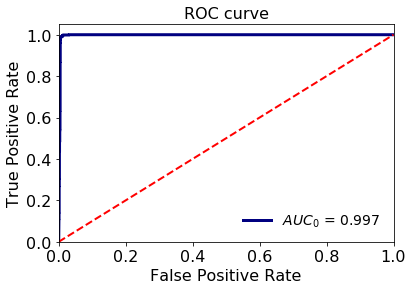

In [246]:
plt.plot(fpr0, tpr0, color='navy', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [257]:
X_train_num, X_test_num, y_train, y_test = train_test_split(
    df_conc[[c for c in df_conc.columns if c != class_name]], df_conc[class_name], 
       test_size=0.3, random_state=100, stratify=df_conc[class_name])

clf = GaussianNB()
clf.fit(X_train_num, y_train)
y_pred = clf.predict(X_test_num)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

Accuracy 0.9828645930340846
F1-score [0.9890241  0.96095076]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4235
           1       0.93      1.00      0.96      1134

    accuracy                           0.98      5369
   macro avg       0.96      0.99      0.97      5369
weighted avg       0.98      0.98      0.98      5369

[0.98592021 0.9845767  0.86619718]


/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [248]:
y_score = clf.predict_proba(X_test_num)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

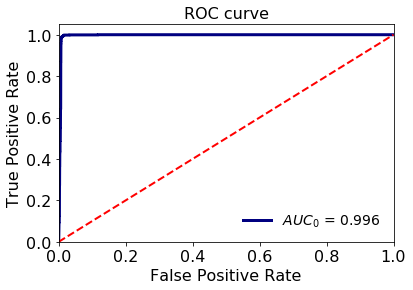

In [249]:
plt.plot(fpr0, tpr0, color='navy', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [250]:
import matplotlib.pyplot

In [251]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [252]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_lift_curve

/Users/marco/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


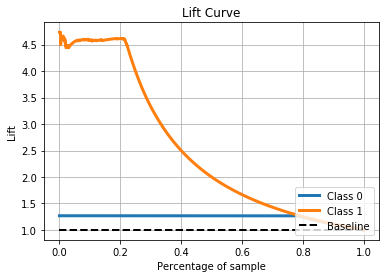

In [253]:
plot_lift_curve(y_test, y_score)
plt.show()

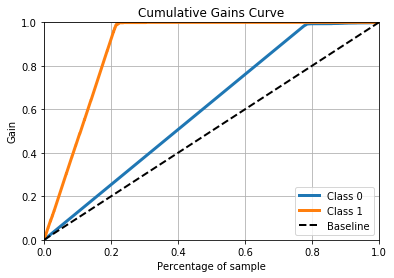

In [254]:
from scikitplot.metrics import plot_cumulative_gain

plot_cumulative_gain(y_test, y_score)
plt.show()